In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,fbeta_score

In [12]:
df=pd.read_csv("dataset.csv",sep=';')
df.head()

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,target
0,38.29,38.29,38.29,38.29,38.29,38.29,38.66,38.66,38.66,38.66,1
1,39.03,38.66,39.03,39.03,39.03,39.03,39.03,39.03,39.03,39.03,1
2,39.41,39.41,39.41,39.41,39.41,39.41,39.78,39.41,39.78,39.78,1
3,39.78,39.78,39.78,39.78,40.15,40.15,40.15,40.15,40.15,40.15,1
4,40.52,40.52,40.52,40.52,40.52,40.52,40.52,40.52,40.52,40.52,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col1    4475 non-null   float64
 1   col2    4475 non-null   float64
 2   col3    4475 non-null   float64
 3   col4    4475 non-null   float64
 4   col5    4475 non-null   float64
 5   col6    4475 non-null   float64
 6   col7    4475 non-null   float64
 7   col8    4475 non-null   float64
 8   col9    4475 non-null   float64
 9   col10   4475 non-null   float64
 10  target  4475 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 384.7 KB


In [14]:
X=df.drop(columns='target')
y=df['target']

In [15]:
y.value_counts()

target
 1    2569
-1    1906
Name: count, dtype: int64

In [16]:
scaler = MinMaxScaler(feature_range=(-1,1))
X_scaled = scaler.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

In [18]:
X_max_train = X_train[y_train == 1]
y_max_train = y_train[y_train == 1]

X_min_train = X_train[y_train == -1]
y_min_train = y_train[y_train == -1]

X_max_test = X_test[y_test == 1]
y_max_test = y_test[y_test == 1]

X_min_test = X_test[y_test == -1]
y_min_test = y_test[y_test == -1]

In [19]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

In [ ]:
def build_generator(input_dim, output_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=input_dim),
        layers.Dense(256, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(output_dim, activation='tanh')
    ])
    return model

# Critic (Discriminator) model
def build_critic(input_dim):
    model = tf.keras.Sequential([
        layers.Dense(512, activation='relu', input_dim=input_dim),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='linear')  # Linear activation for WGAN
    ])
    return model

# Model building
latent_dim = 100
generator = build_generator(latent_dim, X_scaled.shape[1])
critic = build_critic(X_scaled.shape[1])
critic.compile(optimizer='adam', loss=wasserstein_loss)

# GAN model that combines generator and critic
def build_wgan(generator, critic):
    critic.trainable = False
    model = tf.keras.Sequential([generator, critic])
    model.compile(optimizer='adam', loss=wasserstein_loss)
    return model

wgan = build_wgan(generator, critic)

C:\Users\Richard Sitanggang\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def train_wgan(wgan, generator, critic, X_train, epochs=10000, batch_size=128, clip_value=0.01, n_critic=5):
    for epoch in range(epochs):
        for _ in range(n_critic):
            # Train the critic
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            fake_samples = generator.predict(noise)
            
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_samples = X_train[idx]
            
            real_labels = -np.ones((batch_size, 1))
            fake_labels = np.ones((batch_size, 1))
            
            d_loss_real = critic.train_on_batch(real_samples, real_labels)
            d_loss_fake = critic.train_on_batch(fake_samples, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            # Clip weights of critic
            for layer in critic.layers:
                weights = layer.get_weights()
                clipped_weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                layer.set_weights(clipped_weights)
        
        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = -np.ones((batch_size, 1))  # Label for valid/fake samples
        g_loss = wgan.train_on_batch(noise, valid_labels)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Critic Loss: {d_loss}, Generator Loss: {g_loss}")

In [ ]:
train_wgan(wgan, generator, critic, X_min_train, epochs=500)
fake_spam = generator.predict(np.random.normal(0, 1, (X_max_train.shape[0] - len(X_min_train), latent_dim)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


C:\Users\Richard Sitanggang\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 0, Critic Loss: 0.001731571275740862, Generator Loss: [array(0.00163994, dtype=float32), array(0.00163994, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [23]:
X_max_train = np.concatenate([X_max_train, np.full((X_max_train.shape[0] - len(X_max_train), X_scaled.shape[1]), fill_value=0)], axis=0)
X_min_train = X_spam_train = np.concatenate([X_min_train, fake_spam], axis=0)
print(X_max_train.shape)
print(X_min_train.shape)

(2055, 10)
(2055, 10)


In [24]:
y_max_train = np.full(len(X_max_train), 1)
y_min_train = np.full(len(X_min_train), -1)
print(y_max_train.shape)
print(y_min_train.shape)

(2055,)
(2055,)


In [25]:
X_balanced_train = np.concatenate([X_max_train, X_min_train], axis=0)
y_balanced_train = np.concatenate([y_max_train, y_min_train], axis=0)

In [26]:
rf=RandomForestClassifier()
rf.fit(X_balanced_train,y_balanced_train)

RandomForestClassifier()

In [27]:
y_pred=rf.predict(X_test)

In [28]:
acc=accuracy_score(y_pred,y_test)
report=classification_report(y_pred,y_test)
print("Acccuracy: ",acc)
print(report)

Acccuracy:  0.994413407821229
              precision    recall  f1-score   support

          -1       0.99      0.99      0.99       382
           1       0.99      1.00      1.00       513

    accuracy                           0.99       895
   macro avg       0.99      0.99      0.99       895
weighted avg       0.99      0.99      0.99       895



In [29]:
X_balanced_df=pd.DataFrame(X_balanced_train)
y_balanced_df = pd.DataFrame(y_balanced_train, columns=['target'])
df_wgan = pd.concat([X_balanced_df, y_balanced_df], axis=1)

X_scaled_df=pd.DataFrame(X_scaled)
df_scaled = pd.concat([X_scaled_df, y], axis=1)


In [33]:
df_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,target
count,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000
mean,-0.069423,-0.069434,-0.069390,-0.069326,-0.069120,-0.069044,-0.069080,-0.069036,-0.068772,-0.068791,0.148156
std,0.842946,0.842948,0.842913,0.842899,0.842797,0.842786,0.842781,0.842821,0.842705,0.842743,0.989074
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.977635,-0.977635,-0.977635,-0.977635,-0.977635,-0.977635,-0.977635,-0.977635,-0.977635,-0.977635,-1.000000
50%,-0.192719,-0.192719,-0.192719,-0.192719,-0.192719,-0.192719,-0.192719,-0.192482,-0.192719,-0.188675,1.000000
75%,0.876517,0.876517,0.876517,0.876517,0.876517,0.876517,0.876517,0.876517,0.876517,0.876517,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
df_wgan.describe()

,0,1,2,3,4,5,6,7,8,9,target
count,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000,4110.000000
mean,-0.149580,0.060464,-0.091075,0.068653,0.068798,-0.188896,-0.189065,0.015787,0.030798,-0.188830,0.000000
std,0.812803,0.854824,0.787544,0.863195,0.863107,0.844800,0.844925,0.815753,0.826882,0.844937,1.000122
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.973531,-0.973828,-0.973828,-0.973828,-0.973828,-0.987628,-0.987628,-0.973828,-0.973828,-0.987628,-1.000000
50%,-0.603968,0.285748,-0.232690,0.285748,0.285748,-0.623602,-0.623364,0.285748,0.285748,-0.623602,0.000000
75%,0.846538,0.901737,0.846538,0.901737,0.901737,0.846538,0.846538,0.846538,0.846538,0.846538,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


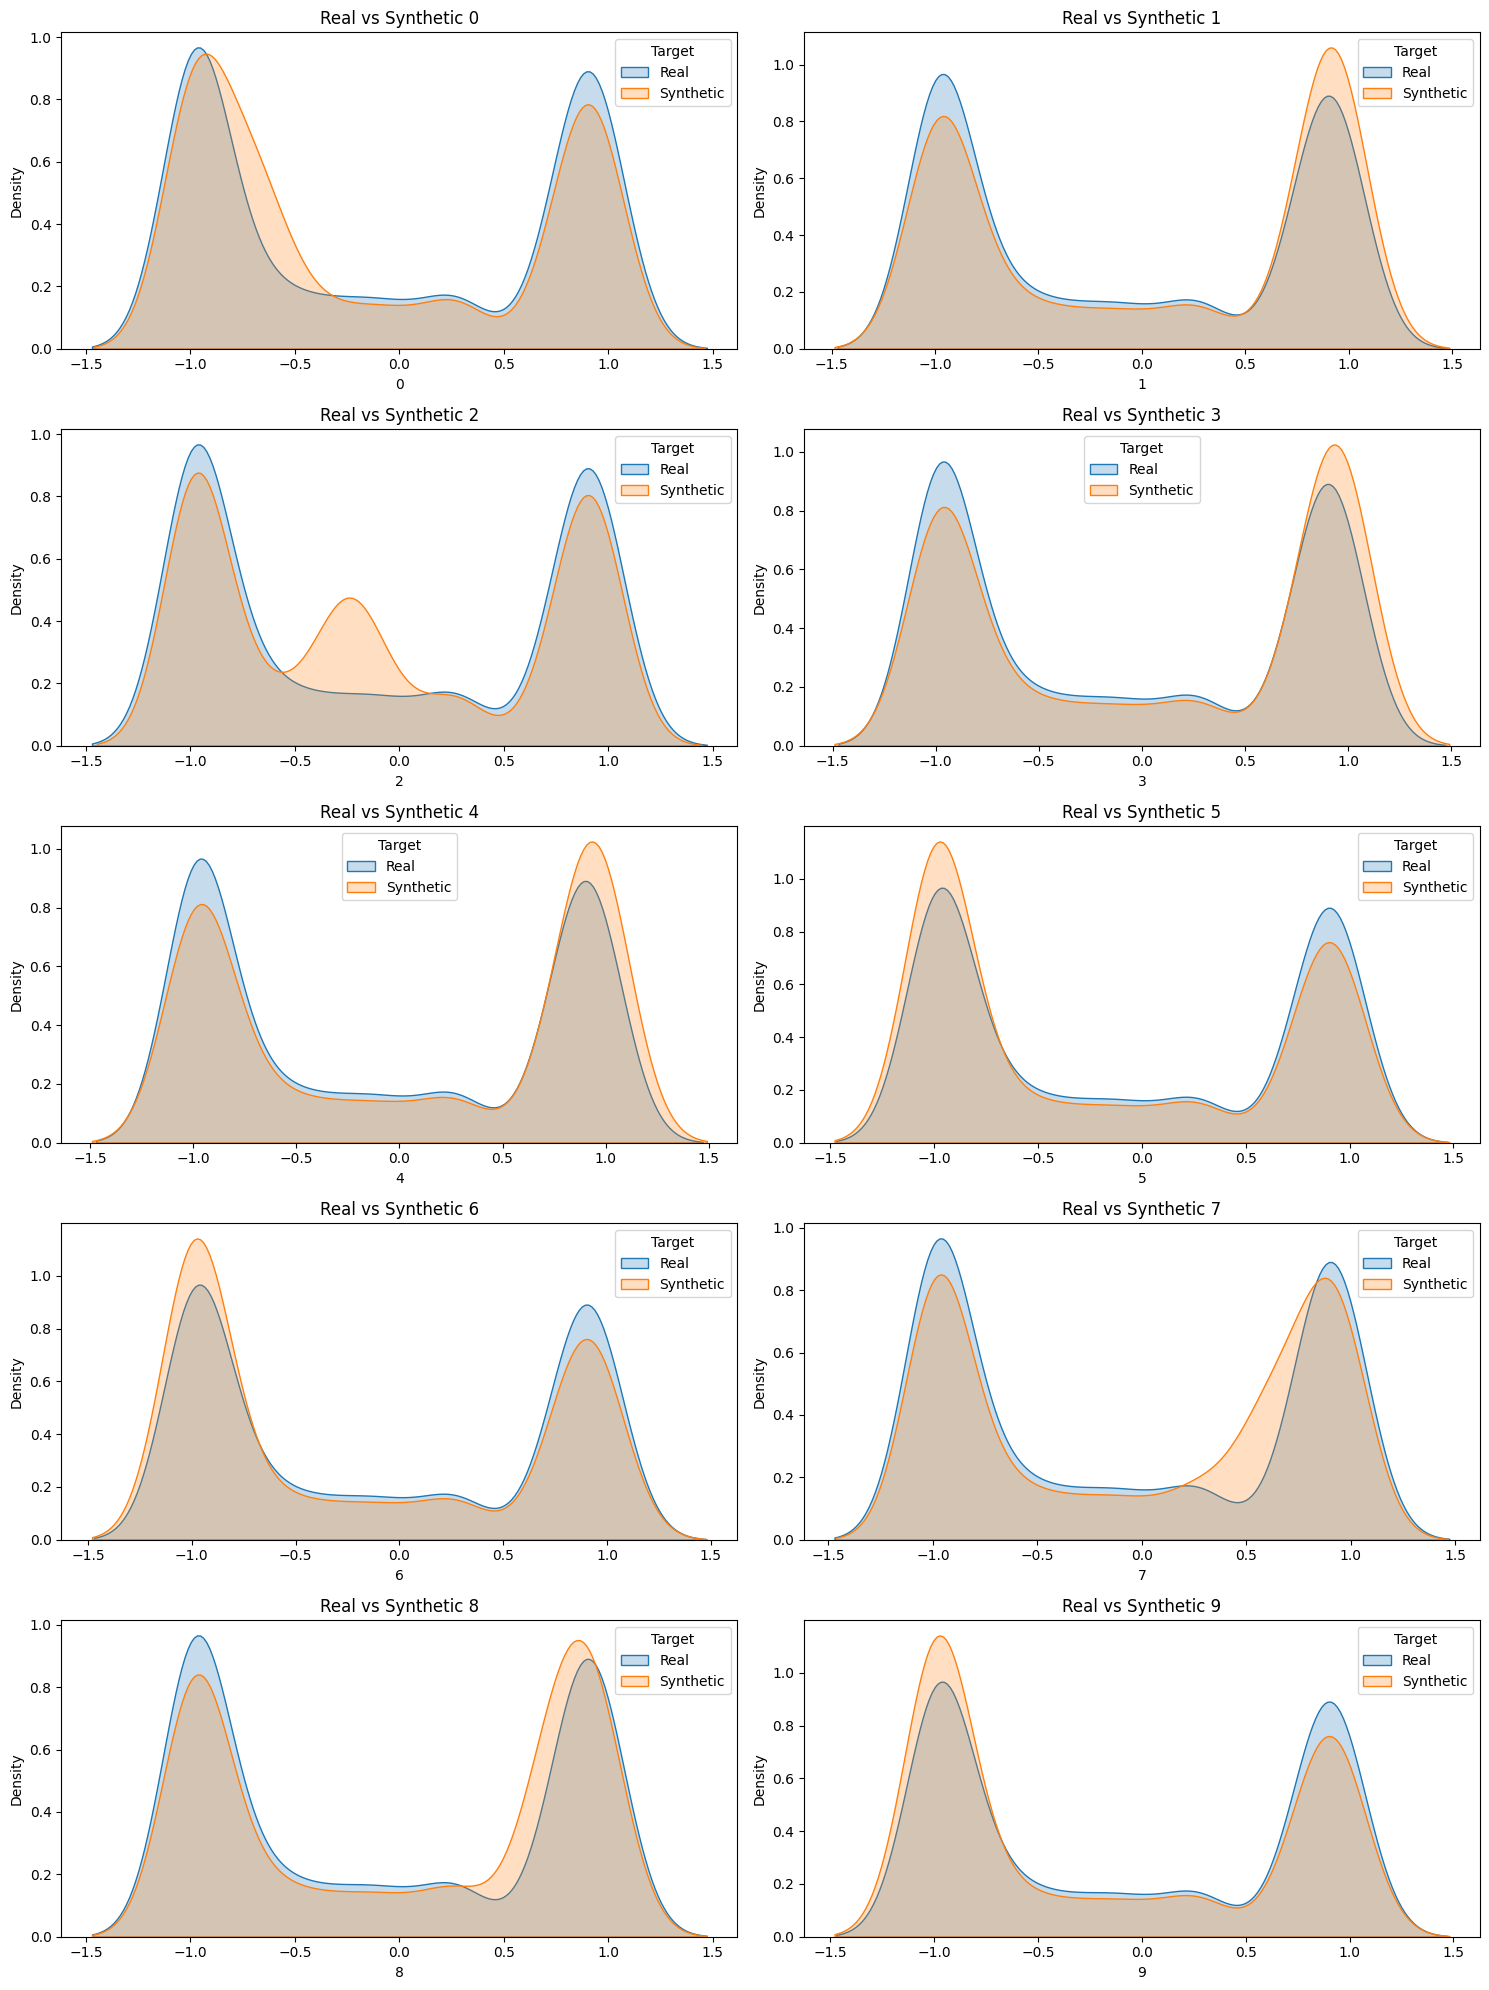

In [32]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

for i, col in enumerate(df_scaled.columns[:-1]):
    row = i // 2 
    col_pos = i % 2 
    
    sns.kdeplot(df_scaled[col], label='Real', fill=True, ax=axes[row, col_pos])
    sns.kdeplot(df_wgan[col], label='Synthetic', fill=True, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(f'Real vs Synthetic {col}')
    axes[row, col_pos].legend(title='Target', loc='best')

plt.tight_layout()
plt.show()